In [362]:
import altair as alt
import plotly.express as px

import pandas as pd
import numpy as np


In [363]:
# Payload
# Deployment Mod
measurement_sizes = {
    'BMP390 Temperature': 4,
    'BMP390 Pressure': 4,
    'LSM6DSL Acc': 4*3,
    'LSM6DSL Gyro': 4*3,
    'GPS All': 32, #
    'Battery INA260': 4*2,
    '3V3 INA260': 4*2,
    'Radio Temp': 1,
}

groups = {
    'LSM6DSL': ['LSM6DSL Acc', 'LSM6DSL Gyro'],
    'BMP390': ['BMP390 Temperature', 'BMP390 Pressure'],
    'GPS,Power': ['GPS All', 'Battery INA260', '3V3 INA260', 'Radio Temp']
}

# seconds
stages = [
    ['boost', 3],
    ['coast', 30],
    ['flight', 302],
    ['ground', 24*60*60] #one day
]

stage_rates = {
    'boost': {'LSM6DSL': 1000, 'BMP390': 100, 'GPS,Power': 1},
    'coast': {'LSM6DSL': 100, 'BMP390': 100, 'GPS,Power': 1},
    'flight': {'LSM6DSL': 100, 'BMP390': 100, 'GPS,Power': 1},
    'ground': {'LSM6DSL': 5, 'BMP390': 1/30, 'GPS,Power': 1/30}
}


timestamp_size_bytes = 4

flash_chip_size_bytes = 128 * 1024 * 1024 / 8


In [364]:
# Deployment Mod
# measurement_sizes = {
#     'BMP390 Temperature': 4,
#     'BMP390 Pressure': 4,
#     'LSM6DSO Acc': 4*3,
#     'LSM6DSO Gyro': 4*3,
#     'MS5611 Press': 4,
#     'MS5611 Temp': 4,
# }
# groups = {
#     'MS5611': ['MS5611 Press', 'MS5611 Temp'],
#     'LSM6DSO': ['LSM6DSO Acc', 'LSM6DSO Gyro'],
#     'BMP390': ['BMP390 Temperature', 'BMP390 Pressure'],
# }

# # ms
# stages = [
#     ['boost', 3],
#     ['ascent', 30],
#     ['flight', 302],
# ]

# stage_rates = {
#     'boost': {'MS5611': 1024, 'LSM6DSO': 416, 'BMP390': 50},
#     'ascent': {'MS5611': 1024, 'LSM6DSO': 208, 'BMP390': 180},
#     'flight': {'MS5611': 512, 'LSM6DSO': 52, 'BMP390': 50},
# }


# timestamp_size_bytes = 4

# flash_chip_size_bytes = 128 * 1024 * 1024

In [365]:
sizedf = pd.DataFrame.from_dict(
    measurement_sizes, orient='index', columns=['size_bytes'])

stageratedf = pd.DataFrame.from_dict(stage_rates).T

stagelendf = pd.DataFrame.from_records(
    stages, columns=['stage', 'time_s'], index='stage')

packetsizedf = pd.DataFrame.from_records([(groupname, sum([measurement_sizes[sensor] for sensor in groups[groupname]]))
                                         for groupname in groups.keys()], columns=['group', 'data'], index='group')
packetsizedf['timestamp'] = timestamp_size_bytes


In [366]:
combined = stageratedf.stack().to_frame(name='read_rate')
combined.index.set_names(['stage', 'group'], inplace=True)

totals = combined.join(packetsizedf) \
    .apply(lambda r: [r['read_rate'] * r['data'], r['read_rate'] * r['timestamp']], axis=1, result_type='expand') \
    .rename(columns={0: 'data', 1: 'timestamp'}).stack().rename('rate').rename_axis(['stage', 'group', 'part']).to_frame()

rates = combined.join(packetsizedf) \
    .apply(lambda r: [r['read_rate'] * r['data'], r['read_rate'] * r['timestamp']], axis=1, result_type='expand') \
    .rename(columns={0: 'data', 1: 'timestamp'}).stack().rename('rate').rename_axis(['stage', 'group', 'part']).to_frame()


In [367]:
packetsizedf['size_with_ts'] = packetsizedf['data']  + packetsizedf['timestamp']

In [368]:
combined


read_rate
stage  group                 
boost  LSM6DSL    1000.000000
       BMP390      100.000000
       GPS,Power     1.000000
coast  LSM6DSL     100.000000
       BMP390      100.000000
       GPS,Power     1.000000
flight LSM6DSL     100.000000
       BMP390      100.000000
       GPS,Power     1.000000
ground LSM6DSL       5.000000
       BMP390        0.033333
       GPS,Power     0.033333

In [369]:
combined['data_byte_rate'] = combined['read_rate'].mul(
    packetsizedf['data'], level=1)
combined['timestamp_byte_rate'] = combined['read_rate'].mul(
    timestamp_size_bytes)
combined['packet_byte_rate'] = combined['read_rate'].mul(
    packetsizedf['size_with_ts'], level=1)


In [370]:
combined

read_rate  data_byte_rate  timestamp_byte_rate  \
stage  group                                                         
boost  LSM6DSL    1000.000000    24000.000000          4000.000000   
       BMP390      100.000000      800.000000           400.000000   
       GPS,Power     1.000000       49.000000             4.000000   
coast  LSM6DSL     100.000000     2400.000000           400.000000   
       BMP390      100.000000      800.000000           400.000000   
       GPS,Power     1.000000       49.000000             4.000000   
flight LSM6DSL     100.000000     2400.000000           400.000000   
       BMP390      100.000000      800.000000           400.000000   
       GPS,Power     1.000000       49.000000             4.000000   
ground LSM6DSL       5.000000      120.000000            20.000000   
       BMP390        0.033333        0.266667             0.133333   
       GPS,Power     0.033333        1.633333             0.133333   

                  packet_byte_rate  
stage  group                        
boost  LSM6DSL        28000.000000  
       BMP390          1200.000000  
       GPS,Power         53.000000  
coast  LSM6DSL         2800.000000  
       BMP390          1200.000000  
       GPS,Power         53.000000  
flight LSM6DSL         2800.000000  
       BMP390          1200.000000  
       GPS,Power         53.000000  
ground LSM6DSL          140.000000  
       BMP390             0.400000  
       GPS,Power          1.766667

In [371]:
combined['num_samples'] = combined['read_rate'].mul(
    stagelendf['time_s']).astype(int)
combined['data_total_bytes'] = combined['num_samples'].mul(
    packetsizedf['size_with_ts'], level=1).astype(int)
combined['timestamp_total_bytes'] = combined['num_samples'].mul(
    timestamp_size_bytes).astype(int)
combined['packet_total_bytes'] = combined['data_total_bytes'] + combined['timestamp_total_bytes']

In [372]:

totals = combined.sum().to_frame(
    'total').T[['data_total_bytes', 'timestamp_total_bytes', 'packet_total_bytes']]
totals


,data_total_bytes,timestamp_total_bytes,packet_total_bytes
total,13716555.0,2031180.0,15747735.0


In [373]:
def littlefs_overhead(length):
    return length * 1.01 + 2048


In [374]:
overhead = pd.concat([totals.map(lambda x : int(littlefs_overhead(x))).rename({'total': 'Including Overhead (B)'}), \
totals.map(lambda x : int(littlefs_overhead(x))/(1024*1024)).rename({'total': 'Including Overhead (MB)'})])
bytes_used_including_overhead = overhead['packet_total_bytes']['Including Overhead (B)']
overhead = overhead.map(lambda f : f"{f:.3f}")


overhead



,data_total_bytes,timestamp_total_bytes,packet_total_bytes
Including Overhead (B),13855768.000,2053539.000,15907260.000
Including Overhead (MB),13.214,1.958,15.170


In [375]:
combined


read_rate  data_byte_rate  timestamp_byte_rate  \
stage  group                                                         
boost  LSM6DSL    1000.000000    24000.000000          4000.000000   
       BMP390      100.000000      800.000000           400.000000   
       GPS,Power     1.000000       49.000000             4.000000   
coast  LSM6DSL     100.000000     2400.000000           400.000000   
       BMP390      100.000000      800.000000           400.000000   
       GPS,Power     1.000000       49.000000             4.000000   
flight LSM6DSL     100.000000     2400.000000           400.000000   
       BMP390      100.000000      800.000000           400.000000   
       GPS,Power     1.000000       49.000000             4.000000   
ground LSM6DSL       5.000000      120.000000            20.000000   
       BMP390        0.033333        0.266667             0.133333   
       GPS,Power     0.033333        1.633333             0.133333   

                  packet_byte_rate  num_samples  data_total_bytes  \
stage  group                                                        
boost  LSM6DSL        28000.000000         3000             84000   
       BMP390          1200.000000          300              3600   
       GPS,Power         53.000000            3               159   
coast  LSM6DSL         2800.000000         3000             84000   
       BMP390          1200.000000         3000             36000   
       GPS,Power         53.000000           30              1590   
flight LSM6DSL         2800.000000        30200            845600   
       BMP390          1200.000000        30200            362400   
       GPS,Power         53.000000          302             16006   
ground LSM6DSL          140.000000       432000          12096000   
       BMP390             0.400000         2880             34560   
       GPS,Power          1.766667         2880            152640   

                  timestamp_total_bytes  packet_total_bytes  
stage  group                                                 
boost  LSM6DSL                    12000               96000  
       BMP390                      1200                4800  
       GPS,Power                     12                 171  
coast  LSM6DSL                    12000               96000  
       BMP390                     12000               48000  
       GPS,Power                    120                1710  
flight LSM6DSL                   120800              966400  
       BMP390                    120800              483200  
       GPS,Power                   1208               17214  
ground LSM6DSL                  1728000            13824000  
       BMP390                     11520               46080  
       GPS,Power                  11520              164160

In [376]:
forDisplay = combined.join(stagelendf).rename(columns={
    'read_rate': 'Sampling Rate (hz)',
    'data_byte_rate': "Data Rate (b/s)",
    'timestamp_byte_rate': "Timestamp Rate (b/s)",
    'packet_byte_rate': "Packet Rate (b/s)",
    'num_samples': 'Total Samples',
    'data_total_bytes': 'Total Sensor Data (b)',
    'timestamp_total_bytes': 'Total Timestamp Data (b)',
    'packet_total_bytes': 'Total Data (b)',
    'time_s': 'Stage Time'
})

forDisplay.set_index(forDisplay.index.map(lambda r: (
    f'{r[0]} ({stagelendf.loc[r[0]]["time_s"]}s)', r[1]))).drop(columns=['Stage Time'])


Sampling Rate (hz)  Data Rate (b/s)  \
stage           group                                            
boost (3s)      LSM6DSL           1000.000000     24000.000000   
                BMP390             100.000000       800.000000   
                GPS,Power            1.000000        49.000000   
coast (30s)     LSM6DSL            100.000000      2400.000000   
                BMP390             100.000000       800.000000   
                GPS,Power            1.000000        49.000000   
flight (302s)   LSM6DSL            100.000000      2400.000000   
                BMP390             100.000000       800.000000   
                GPS,Power            1.000000        49.000000   
ground (86400s) LSM6DSL              5.000000       120.000000   
                BMP390               0.033333         0.266667   
                GPS,Power            0.033333         1.633333   

                           Timestamp Rate (b/s)  Packet Rate (b/s)  \
stage           group                                                
boost (3s)      LSM6DSL             4000.000000       28000.000000   
                BMP390               400.000000        1200.000000   
                GPS,Power              4.000000          53.000000   
coast (30s)     LSM6DSL              400.000000        2800.000000   
                BMP390               400.000000        1200.000000   
                GPS,Power              4.000000          53.000000   
flight (302s)   LSM6DSL              400.000000        2800.000000   
                BMP390               400.000000        1200.000000   
                GPS,Power              4.000000          53.000000   
ground (86400s) LSM6DSL               20.000000         140.000000   
                BMP390                 0.133333           0.400000   
                GPS,Power              0.133333           1.766667   

                           Total Samples  Total Sensor Data (b)  \
stage           group                                             
boost (3s)      LSM6DSL             3000                  84000   
                BMP390               300                   3600   
                GPS,Power              3                    159   
coast (30s)     LSM6DSL             3000                  84000   
                BMP390              3000                  36000   
                GPS,Power             30                   1590   
flight (302s)   LSM6DSL            30200                 845600   
                BMP390             30200                 362400   
                GPS,Power            302                  16006   
ground (86400s) LSM6DSL           432000               12096000   
                BMP390              2880                  34560   
                GPS,Power           2880                 152640   

                           Total Timestamp Data (b)  Total Data (b)  
stage           group                                                
boost (3s)      LSM6DSL                       12000           96000  
                BMP390                         1200            4800  
                GPS,Power                        12             171  
coast (30s)     LSM6DSL                       12000           96000  
                BMP390                        12000           48000  
                GPS,Power                       120            1710  
flight (302s)   LSM6DSL                      120800          966400  
                BMP390                       120800          483200  
                GPS,Power                      1208           17214  
ground (86400s) LSM6DSL                     1728000        13824000  
                BMP390                        11520           46080  
                GPS,Power                     11520          164160

In [377]:
totals2 = combined[['data_total_bytes', 'timestamp_total_bytes', 'packet_total_bytes']] \
    .rename(columns={'data_total_bytes': 'data', 'timestamp_total_bytes': 'timestamp', 'packet_total_bytes': 'packet'}) \
    .stack() \
    .rename('total') \
    .rename_axis(['stage', 'group', 'part']) \
    .to_frame()

rates = combined[['data_byte_rate', 'timestamp_byte_rate', 'packet_byte_rate']] \
    .rename(columns={'data_byte_rate': 'data', 'timestamp_byte_rate': 'timestamp', 'packet_byte_rate': 'packet'}) \
    .stack() \
    .rename('rate') \
    .rename_axis(['stage', 'group', 'part']) \
    .to_frame()


In [378]:
noind = totals2.join(rates).reset_index()
parts = noind[noind['part'] != 'packet'].set_index(['stage', 'group', 'part'])


In [379]:
parts.unstack()


total                    rate             
part                  data timestamp          data    timestamp
stage  group                                                   
boost  BMP390         3600      1200    800.000000   400.000000
       GPS,Power       159        12     49.000000     4.000000
       LSM6DSL       84000     12000  24000.000000  4000.000000
coast  BMP390        36000     12000    800.000000   400.000000
       GPS,Power      1590       120     49.000000     4.000000
       LSM6DSL       84000     12000   2400.000000   400.000000
flight BMP390       362400    120800    800.000000   400.000000
       GPS,Power     16006      1208     49.000000     4.000000
       LSM6DSL      845600    120800   2400.000000   400.000000
ground BMP390        34560     11520      0.266667     0.133333
       GPS,Power    152640     11520      1.633333     0.133333
       LSM6DSL    12096000   1728000    120.000000    20.000000

In [380]:
with_unused = parts.copy()
with_unused['usage'] = 'used'
with_unused = with_unused.reset_index().set_index(['usage', 'stage', 'group', 'part'])
with_unused = pd.concat([with_unused, pd.DataFrame([('unused', 'unused', 'unused', 'unused', flash_chip_size_bytes - bytes_used_including_overhead, 0)], columns=["usage", "stage", "group", "part", "total", "rate"]).set_index(['usage', 'stage', 'group', 'part'])])

In [381]:
fig = px.sunburst(with_unused.reset_index(), path=[
                  'usage','stage', 'group', 'part'], values='total', title=f"Data Usage of {int(flash_chip_size_bytes // 1024 // 1024)}MB")
fig.show()


In [382]:
with_unused.head(1)

,,,,total,rate
usage,stage,group,part,,
used,boost,LSM6DSL,data,84000.0,24000.0


<Axes: ylabel='Total Bytes'>

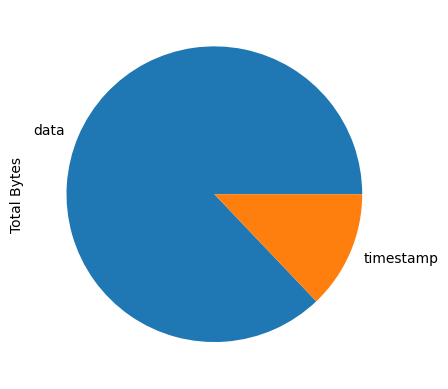

In [383]:
with_unused[with_unused['rate'] != 0].reset_index().drop(columns=['usage']).groupby('part').sum().rename(columns={'total':'Total Bytes'}).plot(kind='pie', y='Total Bytes', legend=False)

<Axes: ylabel='Total Bytes'>

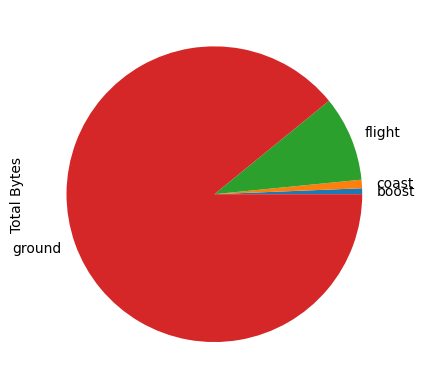

In [386]:
with_unused[with_unused['rate'] != 0].reset_index().drop(columns=['usage']).groupby('stage').sum().rename(columns={'total':'Total Bytes'}).plot(kind='pie', y='Total Bytes', legend=False)